In [25]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchview import draw_graph  # attempts to visualize computational graphs
import matplotlib.pyplot as plt
from ffmpeg_quality_metrics import FfmpegQualityMetrics as ffqm  # for VMAF calculation

# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [11]:
# kolla mer på om detta är rimligt

model_parameters={}
model_parameters['densenet121'] = [6,12,24,16]

# growth rate
k = 32
compression_factor = 0.5

In [12]:
"""
This code is retrieved from https://medium.com/@karuneshu21/implement-densenet-in-pytorch-46374ef91900
Author: Karunesh Upadhyay
"""
class DenseLayer(nn.Module):
    def __init__(self, in_channels):
        """
        First 1x1 convolution generating 4*k number of channels irrespective of the total number of input channels.
        First 3x3 convolution generating k number of channels from the 4*k number of input channels.

        Args:
        in_channels (int) : # input channels to the Dense Layer, default is 3

        """
        super(DenseLayer,self).__init__()

        self.BN1 = nn.BatchNorm2d(num_features=in_channels)
        self.conv1 = nn.Conv2d( in_channels=in_channels , out_channels=4*k , kernel_size=1 , stride=1 , padding=0 , bias = False )

        self.BN2 = nn.BatchNorm2d(num_features = 4*k)
        self.conv2 = nn.Conv2d( in_channels=4*k , out_channels=k , kernel_size=3 , stride=1 , padding=1 , bias = False )

        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        """
        Bottleneck DenseLayer with following operations
        (i) batchnorm -> relu -> 1x1 conv
        (ii) batchnorm -> relu -> 3x3 conv
        
        Concatenation of input and output tensor which is the main idea of DenseNet. 

        Args:
            x (tensor) : input tensor to be passed through the dense layer
        
        Attributes:
            x (tensor) : output tensor 

        """
        x_in = x
        x = self.BN1(x)
        x = self.relu(x)
        x = self.conv1(x)

        x = self.BN2(x)
        x = self.relu(x)
        x = self.conv2(x)
        
        x = torch.cat([x_in, x], 1)
        
        return x


torch.Size([1, 96, 1920, 1080])
DenseLayer(
  (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (BN2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU()
)


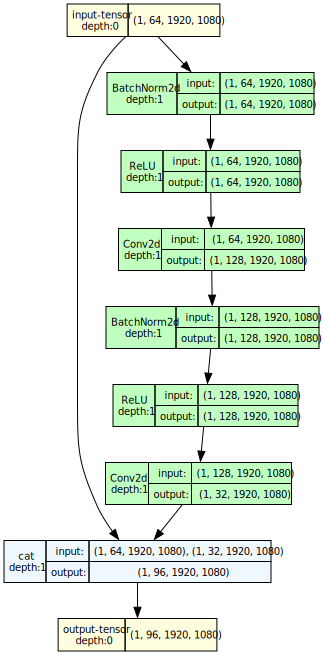

In [23]:
def test_DenseLayer():
    x = torch.randn(1,64,1920,1080)
    model = DenseLayer(64)
    print(model(x).shape)    # maybe change model shape
    print(model)
    # del model
    return model

model = test_DenseLayer()

architecture = 'denselayer'
# model_graph = draw_graph(model, input_size=(1,64,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# Batch size of 1, 64 channels and resolution of 1920x1080
# The batch size represents the number of training examples utilized in one iteration. 
# In this case, with a batch size of 1, the model is updated after processing each individual sample from the training dataset. Training with a batch size of 1 is known as "online" or "stochastic" training, where the model's parameters are updated after processing each data point.
# Channels refer to the number of feature maps or depth in a convolutional neural network (CNN).
model_graph = draw_graph(model, input_size=(1,64,1920,1080), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}')
model_graph.visual_graph

In [21]:
class DenseBlock(nn.Module):
    def __init__(self,layer_num,in_channels):
        """
        Looping through total number of layers in the denseblock. 
        Adding k number of channels in each loop as each layer generates tensor with k channels.
        
        Args:
            layer_num (int) : total number of dense layers in the dense block
            in_channels (int) : input number of channels 
        """

        super(DenseBlock,self).__init__()
        self.layer_num = layer_num
        self.deep_nn = nn.ModuleList()

        for num in range(self.layer_num):
            self.deep_nn.add_module(f"DenseLayer_{num}",DenseLayer(in_channels+k*num))


    def forward(self,x):
        """
        Args:
            x (tensor) : input tensor to be passed through the dense block
        
        Attributes:
            x (tensor) : output tensor 
        """
        x_in = x
        print('xin shape', x_in.shape)

        for layer in self.deep_nn:
            x = layer(x)
            print('xout shape',x.shape)
        return x


xin shape torch.Size([1, 3, 1920, 1080])
xout shape torch.Size([1, 35, 1920, 1080])
xout shape torch.Size([1, 67, 1920, 1080])
xout shape torch.Size([1, 99, 1920, 1080])
Denseblock Output shape :  torch.Size([1, 99, 1920, 1080])
Model  DenseBlock(
  (deep_nn): ModuleList(
    (0): DenseLayer(
      (BN1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (BN2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU()
    )
    (1): DenseLayer(
      (BN1): BatchNorm2d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(35, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (BN2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kerne

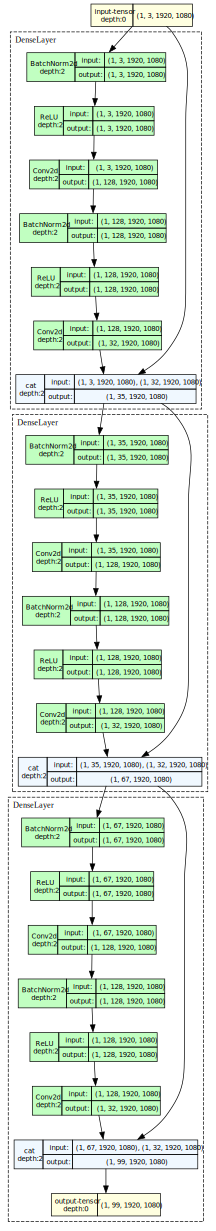

In [24]:
def test_DenseBlock():
    x = torch.randn(1,3,1920,1080)
    model = DenseBlock(3,3)
    print('Denseblock Output shape : ',model(x).shape)
    print('Model ',model)
    # del model
    return model


model = test_DenseBlock()

architecture = 'denseblock'
model_graph = draw_graph(model, input_size=(1,3,1920,1080), graph_dir ='TB' , roll=True, expand_nested=True)
model_graph.visual_graph

In [ ]:
# For testing DenseNet with input size 3 x 1920 x 1080 (Full HD)

def test_DenseNet():
    x = torch.randn(1, 3, 1920, 1080)
    model = DenseNet(model_parameters['densenet121'], k, compression_factor)
    return model


model = test_DenseNet()